In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wfdb
import csv
import os
from scipy.signal import butter, filtfilt
#from PyEMD import EMD
import emd
import time
import pywt
import biosppy.signals.ecg as bsp_ecg
import biosppy.signals.tools as bsp_tools

In [157]:
df = pd.read_csv('data_csv/mit_bih_Arrhythmia/207.csv')#[:20000] #207
mini = 0
maxi = len(df) #10000

ecg_signal = np.array(df["MLII"], dtype=np.float32)
sampling_rate = 360
QRS = df["labels"].dropna().tolist()

QRS = [int(R) for R in QRS if R <= maxi and R <= maxi]

In [176]:
qrs

array([    80,    372,    664, ..., 649488, 649736, 649992])

In [172]:
missed

[2120,
 2412,
 2704,
 2988,
 3272,
 3556,
 3852,
 4080,
 4444,
 4748,
 5040,
 5324,
 5596,
 5904,
 6212,
 6508,
 6808,
 7096,
 7388,
 7676,
 7960,
 8256,
 8568,
 8860,
 9148,
 9436,
 9712,
 9996,
 10288,
 10580,
 10880,
 11184,
 11476,
 11752,
 12040,
 12324,
 12632,
 12936,
 13228,
 13516,
 13824,
 14108,
 14392,
 14688,
 14992,
 15308,
 15604,
 15884,
 16172,
 16464,
 16752,
 17052,
 17352,
 17648,
 17936,
 18224,
 18508,
 18796,
 19100,
 19400,
 19700,
 19988,
 20268,
 20556,
 20832,
 21116,
 21424,
 21736,
 22032,
 22308,
 22596,
 22880,
 23168,
 23460,
 23772,
 24072,
 24364,
 24644,
 24924,
 25200,
 25496,
 25792,
 26096,
 26388,
 26668,
 26956,
 27240,
 27528,
 27816,
 28132,
 28428,
 28712,
 28988,
 29280,
 29572,
 29868,
 30176,
 30472,
 30768,
 31056,
 31336,
 31624,
 31916,
 32224,
 32528,
 32816,
 33108,
 33384,
 33672,
 33964,
 34268,
 34572,
 34872,
 35168,
 35440,
 35728,
 36024,
 36316,
 36616,
 36912,
 37204,
 37496,
 37772,
 38052,
 38352,
 38648,
 38952,
 39256,
 395

In [207]:
len(QRS)

2385

In [206]:
h = wavelet_decomposition(signal, 5, 3)
#h = [min(0.1, x) for x in h]
qrs = np.array(qrs_localization(h, 0.3, sampling_rate))
missed = searchback_missed_qrs(h, qrs, sampling_rate)
#r_peaks = qrs + missed

ValueError: operands could not be broadcast together with shapes (2244,) (122742,) 

In [ ]:
qrs

In [208]:
perf(QRS, qrs, 36)

(596,
 1649,
 1786,
 [array([9]),
  array([312]),
  array([372]),
  array([664]),
  array([835]),
  array([948]),
  array([1078]),
  array([1232]),
  array([1516]),
  array([1588]),
  array([2040]),
  array([2342]),
  array([2404]),
  array([2593]),
  array([2708]),
  array([3000]),
  array([3111]),
  array([3284]),
  array([3357]),
  array([3556]),
  array([4092]),
  array([4172]),
  array([4468]),
  array([4637]),
  array([4768]),
  array([4889]),
  array([5056]),
  array([5348]),
  array([5409]),
  array([5920]),
  array([6160]),
  array([6216]),
  array([6408]),
  array([6528]),
  array([6820]),
  array([6939]),
  array([7108]),
  array([7191]),
  array([7396]),
  array([8248]),
  array([8437]),
  array([8540]),
  array([8694]),
  array([8840]),
  array([9144]),
  array([9215]),
  array([9712]),
  array([9949]),
  array([10000]),
  array([10196]),
  array([10284]),
  array([10592]),
  array([10689]),
  array([10896]),
  array([10939]),
  array([11188]),
  array([11699]),
  array([1

In [204]:
def wavelet_decomposition(sig, idx, nb_wave):
    listos = pywt.wavedec(sig, "haar", level=idx)
    resultat = np.array(insert_zeros(listos[-1], 1))
    resultat = resultat[:len(sig)]
    for i in range(1, idx-nb_wave):
        f = listos[-(i+1)]
        for j in range(i+1):
            f = insert_zeros(f, 1)
        f = f[:len(sig)]
        resultat = np.abs(np.multiply(resultat, np.array(f)))
    return resultat

def insert_zeros(lst, x):
    arr = np.array(lst)
    result = np.zeros(len(arr) + (len(arr) - 1) * x, dtype=arr.dtype)
    result[::x + 1] = arr
    result = np.append(result, 0)
    return result.tolist()

def qrs_localization(h, XX, fs):
    qrs_indices = []
    sous_groupe = []
    w = 1000
    threshold = XX * max(h[:w])
    A = int(fs//10)
    compteur = 0
    for i in range(len(h)):
        if compteur != 0:
            compteur -= 1
            continue
        if i%w == 0 and i != 0:
            threshold = XX * max(h[i-(w//2):i+(w//2)])
        if h[i] >= threshold:
            sous_groupe.append(i)
        elif sous_groupe != [] and i - sous_groupe[-1] >= A: # 36 = valeur donnée dans l'article
            v = max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0]
            qrs_indices.append(v)
            compteur = A * 2 - (i - v)
            sous_groupe = []
    if sous_groupe != []:
        qrs_indices.append(max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
    return qrs_indices

def qrs_localization_normal(h, seuil):
    qrs_indices = []
    sous_groupe = []
    for i in range(len(h)):
        if h[i] >= seuil:
            sous_groupe.append(i)
        elif sous_groupe != [] and i - sous_groupe[-1] >= 36: # 36 = valeur donnée dans l'article
            qrs_indices.append(max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
            sous_groupe = []
    if sous_groupe != []:
        qrs_indices.append(max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
    return qrs_indices

def delete_contraction(r_peaks, fs):
    new_r_peaks = []
    i = 0
    T = 0.2 * fs # 200ms
    while i < len(r_peaks) -1:
        new_r_peaks.append(r_peaks[i])
        if r_peaks[i] + T >= r_peaks[i+1] : # 5 * (fs / 2 )200 correspond à un mouvement du coeur particulier après un battement
            i += 2
        else:
            i += 1
    return new_r_peaks
            
def searchback_missed_qrs(ecg_signal, filtered_indices, fs):
    rr_interval = np.diff(filtered_indices)
    #search_interval = int(v * np.mean(rr_interval))
    missed_peaks = []
    w = int(fs*0.2)
    for i in range(1, len(filtered_indices) - 1):
        if filtered_indices[i+1] - filtered_indices[i] > rr_interval[i-1] * 1.5:
            intervening_segment = ecg_signal[filtered_indices[i]+w:filtered_indices[i+1]-w]
            #a = qrs_localization_normal(ecg_signal, (max(ecg_signal)*0.3*0.5)
            a = qrs_localization(ecg_signal, 0.15, fs)
            missed_peaks.extend([filtered_indices[i] + x for x in a])
    return missed_peaks

In [186]:
def wavelet_decomposition(sig, idx, nb_wave):
    listos = pywt.wavedec(sig, "haar", level=idx)
    resultat = np.array(insert_zeros(listos[-1], 1))
    resultat = resultat[:len(sig)]
    for i in range(1, idx-nb_wave):
        f = listos[-(i+1)]
        for j in range(i+1):
            f = insert_zeros(f, 1)
        f = f[:len(sig)]
        resultat = np.abs(np.multiply(resultat, np.array(f)))
    return resultat

def insert_zeros(lst, x):
    arr = np.array(lst)
    result = np.zeros(len(arr) + (len(arr) - 1) * x, dtype=arr.dtype)
    result[::x + 1] = arr
    result = np.append(result, 0)
    return result.tolist()

def qrs_localization(h, XX, fs):
    qrs_indices = []
    sous_groupe = []
    w = 5000
    threshold = XX * max(h[:w])
    A = int(fs//10)
    compteur = 0
    for i in range(len(h)):
        if compteur != 0:
            compteur -= 1
            continue
        if i%w == 0 and i != 0:
            threshold = XX * max(h[i-(w//2):i+(w//2)])
        if h[i] >= threshold:
            sous_groupe.append(i)
        elif sous_groupe != [] and i - sous_groupe[-1] >= A: # 36 = valeur donnée dans l'article
            v = max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0]
            qrs_indices.append(v)
            compteur = A # - (i - v)
            sous_groupe = []
    if sous_groupe != []:
        qrs_indices.append(max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
    return qrs_indices

def qrs_localization_normal(h, seuil):
    qrs_indices = []
    sous_groupe = []
    seuil = seuil * max(h)
    for i in range(len(h)):
        if h[i] >= seuil:
            sous_groupe.append(i)
        elif sous_groupe != [] and i - sous_groupe[-1] >= 36: # 36 = valeur donnée dans l'article
            qrs_indices.append(max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
            sous_groupe = []
    if sous_groupe != []:
        qrs_indices.append(max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
    return qrs_indices

def delete_contraction(r_peaks, fs):
    new_r_peaks = []
    i = 0
    T = 0.2 * fs # 200ms
    while i < len(r_peaks) -1:
        new_r_peaks.append(r_peaks[i])
        if r_peaks[i] + T >= r_peaks[i+1] : # 5 * (fs / 2 )200 correspond à un mouvement du coeur particulier après un battement
            i += 2
        else:
            i += 1
    return new_r_peaks
            
def searchback_missed_qrs(ecg_signal, filtered_indices, fs):
    rr_interval = np.diff(filtered_indices)
    #search_interval = int(v * np.mean(rr_interval))
    missed_peaks = []
    w = int(fs*0.2)
    for i in range(1, len(filtered_indices) - 1):
        if filtered_indices[i+1] - filtered_indices[i] > rr_interval[i-1] * 1.5:
            intervening_segment = ecg_signal[filtered_indices[i]+w:filtered_indices[i+1]-w]
            #a = qrs_localization_normal(ecg_signal, (max(ecg_signal)*0.3*0.5)
            a = qrs_localization(ecg_signal, 0.3*0.5, fs)
            a = delete_contraction(a, fs)
            missed_peaks.extend([filtered_indices[i] + x for x in a])
    return missed_peaks

In [131]:
def print_signal(signal, description="a"):
    print(f"signal de longueur: {len(signal)}")
    plt.figure()
    plt.plot(signal)
    plt.axhline(y=(max(signal)*0.3), color='r', linestyle='-', label = "first")
    plt.axhline(y=(max(signal)*0.3)*0.5, color='g', linestyle='-', label = "second")
    #plt.scatter(QRS, [signal[i] for i in QRS], color='red')
    plt.title(label= description)
    plt.show()
    
def print_signal_qrs(signal, description, qrs):
    print(f"signal de longueur: {len(signal)}")
    plt.figure()
    plt.plot(signal)
    plt.scatter(qrs, [signal[i] for i in qrs], color='red')
    plt.title(label= description)
    plt.show()
    
def perf(labels, peaks, minmax):
    x = np.concatenate([np.array(labels), np.array(peaks)]) #list(set(QRS + r_peaks))
    x.sort()
    diff = x[1:]-x[:-1]
    gps = np.concatenate([[0], np.cumsum(diff>=minmax)])
    temp = [x[gps==i] for i in range(gps[-1]+1)]
    TP = 0
    FP = 0
    FN = 0
    list_F = []
    for sublist in temp:
        if len(sublist) == 2:
            TP += 1
        else:
            list_F.append(sublist)
            if sublist[0] in labels:
                FN += 1
            else:
                FP += 1
    return TP, FP, FN, list_F

In [7]:
def extend_list_with_averages(input_list):
    extended_list = [input_list[0]]
    length = len(input_list)

    for i in range(length - 1):
        current_element = input_list[i]
        next_element = input_list[i + 1]
        average = (current_element + next_element) / 2
        extended_list.append(average)
        extended_list.append(next_element)

    return extended_list

In [8]:
start = time.time()
performance = pd.DataFrame()
for fichier in os.listdir("data_csv/mit_bih_Arrhythmia/"):
    df = pd.read_csv(f'data_csv/mit_bih_Arrhythmia/{fichier}')
    if "MLII" not in df.columns:
        continue
    signal = np.array(df["MLII"], dtype=np.float32)
    sampling_rate = 360
    QRS = df["labels"].dropna().tolist()
    r_peaks = full_wavelets(signal)

    perf_temp = perf(QRS, r_peaks, 72)
    performance = pd.concat([performance, pd.DataFrame({"data" : fichier[:-4], "TP": perf_temp[0], "FP": perf_temp[1], "FN":perf_temp[2]}, index=[0])], ignore_index=True)
performance["Sensi"] = performance["TP"] / (performance["TP"] + performance["FN"])
performance["Specificity"] = performance["TP"] / (performance["TP"] + performance["FP"])
performance["f1_score"] = (2 * performance["TP"]) / (2 * performance["TP"] + performance["FN"] + performance["FP"])
performance.sort_values("f1_score", inplace = True)

print(f"f1_score = {np.mean(performance['f1_score'].tolist())} / Sensi = {np.mean(performance['Sensi'].tolist())} / Spec = {np.mean(performance['Specificity'].tolist())}")
end = time.time()
print(end - start)

NameError: name 'full_wavelets' is not defined

In [ ]:
def full_wavelets(signal):
    h = wavelet_decomposition(signal, 5)
    h = extend_list_with_averages(h)
    threshold = 0.3 * max(h)
    qrs = np.array(qrs_localization(h, threshold))
    qrs.sort()
    qrs = delete_contraction(qrs, sampling_rate)
    qrs = qrs + searchback_missed_qrs(h, qrs, 360)
    return qrs

In [65]:
df = pd.read_csv('data_csv/mit_bih_Arrhythmia/207.csv') #207
signal = np.array(df["MLII"], dtype=np.float32)
sampling_rate = 360
maxi = len(df)
mini = 0
signal = signal[mini:maxi]
QRS = df["labels"].dropna().tolist()
QRS = [int(R) for R in QRS if R <= maxi and R <= maxi]

[    58    306    842 ... 649598 649794 649992]
signal de longueur: 649999


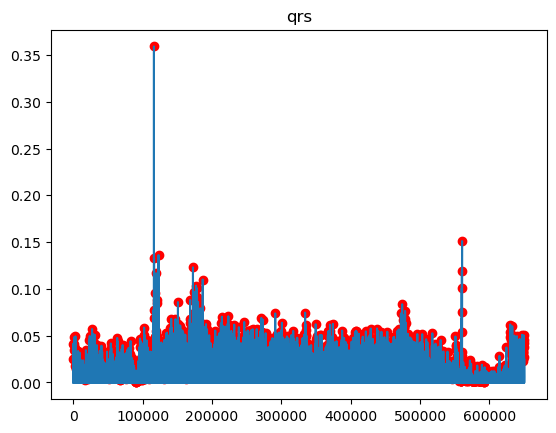

In [70]:
h = wavelet_decomposition(signal, 5)
#print_signal(d4, "wavelets")
#print_signal(d5, "wavelets")
h = extend_list_with_averages(h)
#print_signal(h, "PI")
threshold = 0.2 * max(h)
qrs = np.array(qrs_localization(h, threshold))
print(str(qrs))
qrs.sort()
qrs = delete_contraction(qrs, sampling_rate)
print_signal_qrs(h, "qrs", qrs)

In [73]:
perf(QRS, qrs, 36)
# 2087,  117,  249,

(2135,
 155,
 231,
 [array([9]),
  array([13868]),
  array([14414]),
  array([14754]),
  array([15118, 15138, 15162]),
  array([15759]),
  array([15798]),
  array([16138]),
  array([17346]),
  array([17406]),
  array([17470]),
  array([17618]),
  array([17658]),
  array([17730]),
  array([17788]),
  array([17857]),
  array([17914]),
  array([17976]),
  array([18068]),
  array([18132]),
  array([18350]),
  array([18396]),
  array([19715]),
  array([19760]),
  array([20168, 20183, 20218]),
  array([20962]),
  array([21056]),
  array([21092]),
  array([21731]),
  array([21827]),
  array([22262]),
  array([22774]),
  array([25627]),
  array([27256]),
  array([46025]),
  array([48133]),
  array([55103]),
  array([55775]),
  array([64967]),
  array([65681]),
  array([66375]),
  array([69978]),
  array([71340]),
  array([73494]),
  array([74943]),
  array([83557]),
  array([86540]),
  array([87172]),
  array([87214]),
  array([88202]),
  array([88259]),
  array([88716]),
  array([88788]),
  a

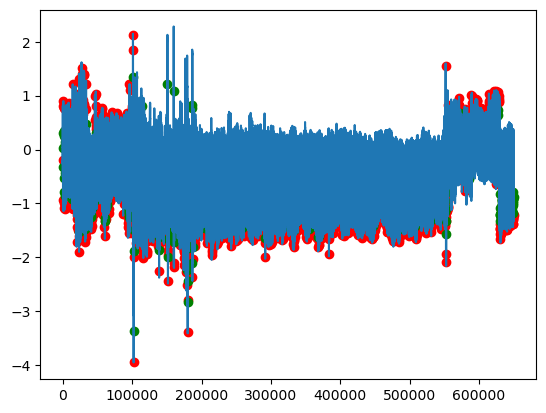

In [60]:
plt.figure()
plt.plot(signal[:maxi])
qrs = [x * 2 for x in qrs]
plt.scatter(QRS, [signal[i] for i in QRS], color='red', label = "label")
plt.scatter(qrs, [signal[i] for i in qrs], color='green', label = "predict")
plt.show()

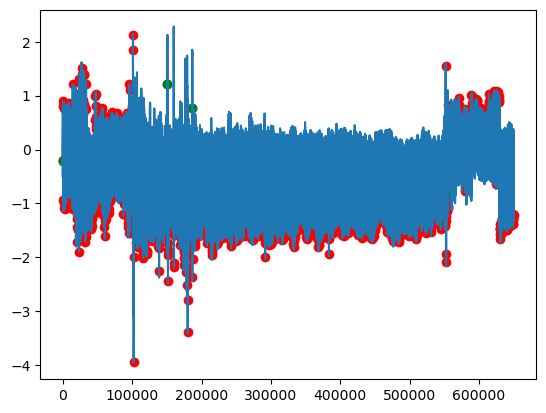

In [16]:
plt.figure()
plt.plot(signal[:maxi])
qrs = qrs*2
plt.scatter(QRS, [signal[i] for i in QRS], color='red', label = "label")
plt.scatter(qrs, [signal[i] for i in qrs], color='green', label = "predict")
plt.show()

In [67]:
def perf(labels, peaks, minmax):
    x = np.concatenate([np.array(labels), np.array(peaks)]) #list(set(QRS + r_peaks))
    x.sort()
    diff = x[1:]-x[:-1]
    gps = np.concatenate([[0], np.cumsum(diff>=minmax)])
    temp = [x[gps==i] for i in range(gps[-1]+1)]
    TP = 0
    FP = 0
    FN = 0
    list_F = []
    for sublist in temp:
        if len(sublist) == 2:
            TP += 1
        else:
            list_F.append(sublist)
            if sublist[0] in labels:
                FN += 1
            else:
                FP += 1
    return TP, FP, FN, list_F

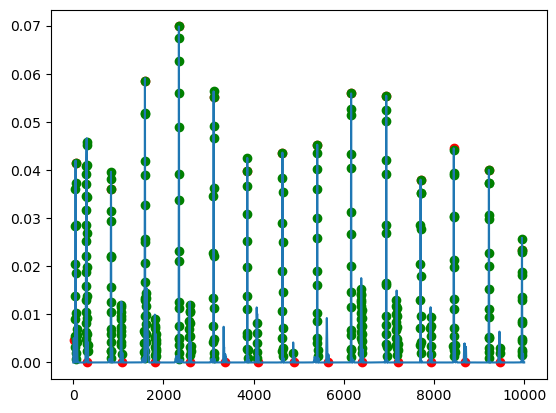

In [34]:
plt.figure()
plt.plot(filtered_signal[:max])
plt.scatter(QRS, [filtered_signal[i] for i in QRS], color='red')
plt.scatter(r_peaks, [filtered_signal[i] for i in r_peaks], color='green')
plt.show()